# Loading the Functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def get_DDM_traces(v=1, z=0.5, a=1, dc=0, dc_slope=0, sv=0.1, noise_sd=1, stim=0, nr_trials=1000, tmax=5.0, dt=0.01):
    
    """
    DDM

    v:  mean drift rate
    z:  starting point
    dc: drift criterion
    """
    
    if stim == 0:
        v = np.random.normal(-v,sv,nr_trials)
    elif stim == 1:
        v = np.random.normal(v,sv,nr_trials)
    x = np.zeros((nr_trials, int(tmax/dt)))
    x[:,:] = np.NaN
    for i in range((int(tmax/dt))-1):
        x[:,i+1] = x[:,i] + ((v + dc + (dc_slope*dt*i) ) * dt) + (np.random.normal(0,noise_sd,nr_trials)*np.sqrt(dt))
    return x

In [7]:
def _bounds(a, lower_is_0=True, tmax=5, dt=0.01):
    t = np.arange(0, tmax, dt)
    b1 = np.ones(len(t)) * a
    if lower_is_0:
        b0 = np.zeros(len(t))
    else:
        b0 = -b1
    return b1, b0

In [8]:
from numba import jit

In [9]:
@jit(nopython=True)
def apply_bounds_diff_trace(x, b1, b0):
    rt = np.zeros(x.shape[0])
    response = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i,j] >= b1[j]:
                rt[i] = j
                response[i] = 1
                break
            elif x[i,j] <= b0[j]:
                rt[i] = j
                response[i] = 0
                break
    return rt, response

# Doing the Simulation

In [32]:
x = get_DDM_traces(v=1, z=0.5, dc=0, dc_slope=0, sv=0, noise_sd=1, stim=1, nr_trials=1000, tmax=5.0, dt=0.01)
b1, b0 = _bounds(a=1, lower_is_0=True, tmax=5, dt=0.01)
rt, response = apply_bounds_diff_trace(x, b1, b0)

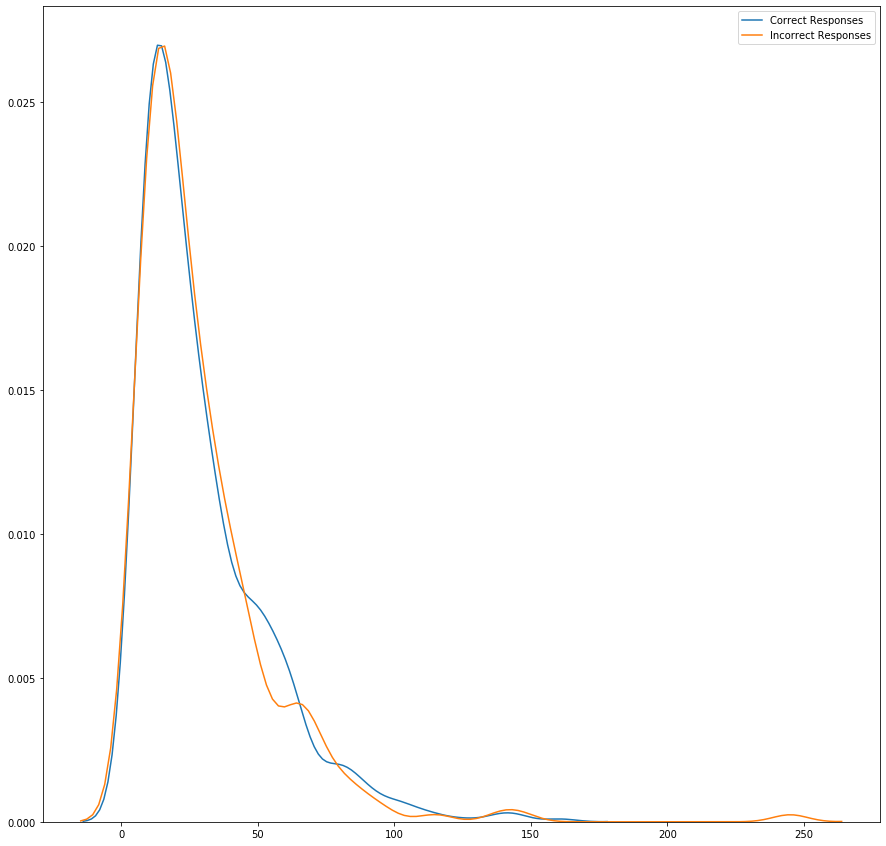

In [33]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.distplot(rt[response ==1], hist=False, label = 'Correct Responses')
sns.distplot(rt[response ==0], hist=False, label = 'Incorrect Responses')
plt.legend()

# Creating a function to plot based on some variables

In [12]:
%matplotlib inline
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
import pandas as pd

In [172]:
import time
def func(v, z, dc, a, ter):
    
    trials = 10000
    
    dt = 0.01
    x = get_DDM_traces(v=v, z=z*a, dc=dc, dc_slope=0, sv=0, noise_sd=1, stim=1, nr_trials=trials, tmax=5.0, dt=0.01)
    b1, b0 = _bounds(a=a, lower_is_0=True, tmax=5, dt=0.01)
    rt, response = apply_bounds_diff_trace(x, b1, b0)
    df1 = pd.DataFrame({'rt' : rt, 'response' : response})

    x = get_DDM_traces(v=v, z=z*a, dc=dc, dc_slope=0, sv=0, noise_sd=1, stim=0, nr_trials=trials, tmax=5.0, dt=0.01)
    b1, b0 = _bounds(a=a, lower_is_0=True, tmax=5, dt=0.01)
    rt, response = apply_bounds_diff_trace(x, b1, b0)
    df2 = pd.DataFrame({'rt' : rt, 'response' : response}, index = range(trials, trials*2))


    df = df1.append(df2)
    df['rt'] = (df['rt'] * 0.01) + ter
    df['stimulus'] = np.concatenate([np.ones(trials), np.zeros(trials)])
    df['correct'] = df['response'] == df['stimulus']
    df['rt quantiles'] = pd.qcut(df['rt'], 5, labels = False)


    sns.kdeplot(df['rt'][df['correct']], label = 'correct')
    sns.kdeplot(df['rt'][df['correct'] == False], label = 'incorrect')
    plt.xlim([0, 5])
    
    plt.figure()
    gb = df.groupby('rt quantiles').mean()
    plt.plot(gb['correct'], 'ro-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label ='accuracy', markeredgewidth = 2)
    plt.plot(gb['response'], 'go-', linewidth = 0.5, markerfacecolor = 'none', markersize = 10, label = 'bias', markeredgewidth = 2)
    plt.xticks(np.arange(0, 5))
    plt.legend()
    
    plt.figure()
    plt.axhline(a, color = 'red')
    plt.ylim([0, a + 0.1])
    plt.xlim([0, 1])

    x = np.zeros(200)
    x[0] = z*a
    for i in range(1, x.shape[0]):
        x[i] = x[i-1] + (dc + v)*0.01
    plt.plot(np.arange(0, 2, dt),  x, color = 'black')

    x = np.zeros(200)
    x[0] = z*a
    for i in range(1, x.shape[0]):
        x[i] = x[i-1] + (dc + -v)*0.01

    plt.plot(np.arange(0, 2, dt),  x, color =  'black')
    
#     print(time.time() - start)

In [173]:
w = interactive(func, v= (0, 2.0),z= (0, 1.0) , dc = (-1.0, 1.0), a = (0.0, 3.0), ter = (0.0, 2.0))
display(w)

interactive(children=(FloatSlider(value=1.0, description='v', max=2.0), FloatSlider(value=0.5, description='z'…

# My code for experimenting with random stuff

In [18]:
zeros = pd.DataFrame({'a' : np.zeros(10)})

In [25]:
ones = pd.DataFrame({'a' : np.ones(10)}, index = range(10, 20))

In [26]:
pd.concat([zeros, ones])

,a
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [35]:
x = get_DDM_traces(v=1, z=0.5, dc=0, dc_slope=0, sv=0, noise_sd=1, stim=1, nr_trials=1000, tmax=5.0, dt=0.01)
b1, b0 = _bounds(a=3, lower_is_0=True, tmax=5, dt=0.01)
rt, response = apply_bounds_diff_trace(x, b1, b0)

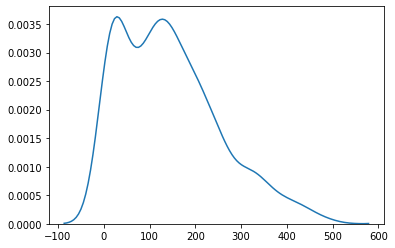

In [36]:
sns.kdeplot(rt)

In [37]:
x = get_DDM_traces(v=1, z=0.5, dc=0, dc_slope=0, sv=0, noise_sd=1, stim=0, nr_trials=1000, tmax=5.0, dt=0.01)
b1, b0 = _bounds(a=3, lower_is_0=True, tmax=5, dt=0.01)
rt, response = apply_bounds_diff_trace(x, b1, b0)

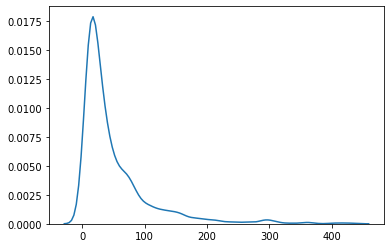

In [38]:
sns.kdeplot(rt)

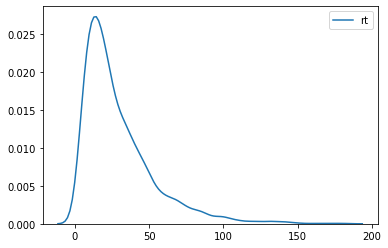

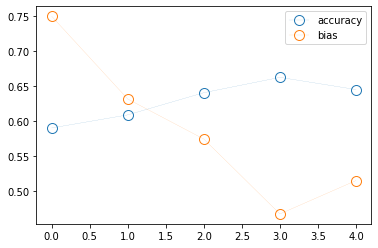

In [112]:
v = 0.5
z = 0.6
dc = 0
trials = 1000

x = get_DDM_traces(v=v, z=z, dc=dc, dc_slope=0, sv=0, noise_sd=1, stim=1, nr_trials=trials, tmax=5.0, dt=0.01)
b1, b0 = _bounds(a=1, lower_is_0=True, tmax=5, dt=0.01)
rt, response = apply_bounds_diff_trace(x, b1, b0)
df1 = pd.DataFrame({'rt' : rt, 'response' : response})

x = get_DDM_traces(v=v, z=z, dc=dc, dc_slope=0, sv=0, noise_sd=1, stim=0, nr_trials=trials, tmax=5.0, dt=0.01)
b1, b0 = _bounds(a=1, lower_is_0=True, tmax=5, dt=0.01)
rt, response = apply_bounds_diff_trace(x, b1, b0)
df2 = pd.DataFrame({'rt' : rt, 'response' : response}, index = range(trials, trials*2))


df = df1.append(df2)
df['stimulus'] = np.concatenate([np.ones(trials), np.zeros(trials)])
df['correct'] = df['response'] == df['stimulus']
df['rt quantiles'] = pd.qcut(df['rt'], 5, labels = False)


sns.kdeplot(df['rt'])

plt.figure()
gb = df.groupby('rt quantiles').mean()
plt.plot(gb['correct'], 'o-', linewidth = 0.1, markerfacecolor = 'none', markersize = 10, label ='accuracy')
plt.plot(gb['response'], 'o-', linewidth = 0.1, markerfacecolor = 'none', markersize = 10, label = 'bias')
plt.legend()

In [67]:
df

,rt,response,stimulus,correct
0,7.0,1.0,1.0,True
1,33.0,1.0,1.0,True
2,11.0,1.0,1.0,True
3,78.0,1.0,1.0,True
4,64.0,0.0,1.0,False
5,33.0,1.0,1.0,True
6,25.0,1.0,1.0,True
7,52.0,1.0,1.0,True
8,27.0,1.0,1.0,True
9,17.0,1.0,1.0,True


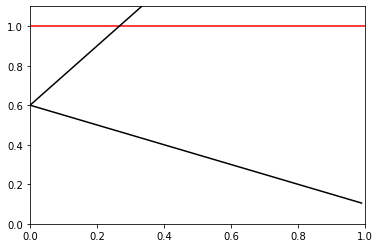

In [96]:
v = 1
z = 0.6
dc = 0.5
a = 1
dt = 0.01

plt.axhline(a, color = 'red')
plt.ylim([0, 1.1])
plt.xlim([0, 1])

x = np.zeros(100)
x[0] = z
for i in range(1, x.shape[0]):
    x[i] = x[i-1] + (dc + v)*0.01
plt.plot(np.arange(0, 1, dt),  x, color = 'black')
    
x = np.zeros(100)
x[0] = z
for i in range(1, x.shape[0]):
    x[i] = x[i-1] + (dc + -v)*0.01

plt.plot(np.arange(0, 1, dt),  x, color =  'black')




In [86]:


np.arange(0,1, 0.01)
    

(100,)

array([0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 , 0.635, 0.64 ,
       0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675, 0.68 , 0.685,
       0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 , 0.725, 0.73 ,
       0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765, 0.77 , 0.775,
       0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 , 0.815, 0.82 ,
       0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 , 0.855, 0.86 , 0.865,
       0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895, 0.9  , 0.905, 0.91 ,
       0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 , 0.945, 0.95 , 0.955,
       0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 , 0.995, 1.   ,
       1.005, 1.01 , 1.015, 1.02 , 1.025, 1.03 , 1.035, 1.04 , 1.045,
       1.05 , 1.055, 1.06 , 1.065, 1.07 , 1.075, 1.08 , 1.085, 1.09 ,
       1.095])

# Testing some numba stuff

In [151]:
import numba

@numba.njit
def testNumba():
    for i in range(1000):
        for j in range(1000):
            for k in range(100):
                i + j + k

In [154]:
testNumba()

In [145]:
from numba import autojit, prange

@autojit
def testNumba():
    for i in prange(1000):
        for j in prange(1000):
            for k in prange(100):
                i + j + k    


In [150]:
testNumba()

# Changing the DDM Trace Function

In [215]:
import numba

def get_sim_noise(trials=1000, stimulus=1, noise_sd=1, start_stim = 1, end_stim = 4, tmax = 5, dt = 0.01):
    noise = np.zeros(shape = (trials, int(tmax/dt)))
    
    if stimulus == 1:
        start = int(start_stim / dt)
        end = int(end_stim / dt)
        noise[:, start:end] = 1
    
    for i in range(int(tmax/dt)):
        noise[:, i] += np.random.normal(0, noise_sd, trials)*np.sqrt(dt)    
    
    return noise

In [ ]:
def get_DDM_traces_noise(v, z=0.5, a=1,. dc=0, dc_slope=0, sv=0.1, noise_sd=1, nr_trials=1000, tmax=5.0, dt=0.01):
    
    """
    DDM

    v:  mean drift rate
    z:  starting point
    dc: drift criterion
    """
    x = np.zeros((nr_trials, int(tmax/dt)))
    x[:,:] = np.NaN
    x[:,0] = z*a
    for i in range(1, int(tmax/dt)):
        x[:,i] += ((v[:, i] + dc + (dc_slope*dt*i) ) * dt)
    return x